# Damage model 
The original model is 

\begin{equation}\label{eq: original model}
y^*  = y \cdot I\{c \cdot y > l\} + \alpha \cdot y \cdot I\{c \cdot y < l\}
\end{equation}



# Smooth function

Note that we have the indicator function in the model we might consider the smooth function:
\begin{equation}\label{eq: trans function}
S(x;s) = \frac{1}{1 + \exp(-s \cdot x)}
\end{equation},
where $s$ is the smoothing hyper-parameter to control the smoothness. 

Then the model becomes 
$$
y^*  = y \cdot \frac{1}{1 + \exp(-s\cdot(cy-l))} + \alpha \cdot y \cdot \frac{1}{1 + \exp(-s\cdot(l-cy))}
$$

We have $y \geq y^*$.

The lumber have three groups:

- Group 1: $y <l$, $y^* < l$, i.e., $y^* <y < l$. The lumber pieces are broken blow the proof loading.
- Group 2: $y >l$, $y^* < l$, i.e. $y^*<l<y$. The lumber pieces are broken during the proof loading process. This groups we only knows how many pieces. 
- Group 3: $y >l$, $y^* > l$, i.e. $l<y^*<y$. The lumber pieces survived in the proof-loading. And then we destruct them to test their strength.


# The PDF calculation 

Given $Y \sim N(\mu, \sigma^2)$, $Y^* = h(Y)$. Then the pdf of $Y^*$,
$$
f_{Y^*}(y^*) = f_{Y}(h^{-1}(y^*))|\frac{d}{dy^*}h^{-1}(y^*)|,
$$
where $f_Y()$ is the pdf of $Y$, i.e., normal. 

Following this, We need the numerical function of $h^{-1}(y^*)$, and its numerical gradient $\frac{d}{dy^*}h^{-1}(y^*)$. (The analytical form doesn't seem available.)

In [1]:
import jax
import jaxopt
import jax.numpy as jnp
import pyreadr
import projplot as pjp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
@jax.jit


def logit(x):
    return(jnp.log(x/(1-x)))


def expit(x):
    return 1/(1+jnp.exp(-x))




def sigmoid(x, s):
    # x = jnp.array(x)
    # a = jnp.array(a)
    return 0.5 * (jnp.tanh(x * s / 2) + 1)

def dmgmodel_py(y,alpha,l,c,s):
    y = jnp.array(y)
    return(y*sigmoid(c*y-l,s) + alpha*y*sigmoid(l-c*y,s))

def dmgmodel_root_py(y,alpha,l,c,s,ystar):
    return(dmgmodel_py(y,alpha,l,c,s) - ystar)



def dmginverse_py(ystar,alpha,l,c,s):
    """
    Calculate the root of `Teqn()`.
    """
    def root_fun(y):
        return dmgmodel_root_py(y = y,alpha = alpha,l = l,
                                c = c,s = s,ystar = ystar)

    def solve(root_fun, Ts_init):
        bisec = jaxopt.Bisection(
            optimality_fun=root_fun,
            lower = 0,
            upper = 10000,
            check_bracket=False
        )
        return bisec.run().params

    def tangent_solve(g, y):
        return y/g(1.0)

    return jax.lax.custom_root(
        f=root_fun,
        initial_guess=50., # dummy value
        solve=solve,
        tangent_solve=tangent_solve,
        has_aux=False   # could set this to True if we wanted to return convergence results from `bisec.run()`
    )


def dmginvgrad_py(ystar,alpha,l,c,s):
    grad_func = jax.grad(dmginverse_py,0)
    return(jnp.abs(grad_func(ystar,alpha,l,c,s)))

def dmglik_py(ystar,alpha,l,c,s,mu,sigma):
    y =  dmginverse_py(ystar,alpha,l,c,s)
    return(jax.scipy.stats.norm.logpdf(y,loc = mu,scale = sigma)+ 
           jnp.log(dmginvgrad_py(ystar,alpha,l,c,s))
          )


def dmglik_vmap(y_group,alpha,l,c,s,mu,sigma):
    y_group = jnp.array(y_group)
    lik = jax.vmap(lambda y_group: dmglik_py(ystar = y_group,
                                             alpha = alpha,l = l, c= c,s =s,mu = mu, sigma=sigma))(y_group)
    return(jnp.sum(lik))



In [3]:
# # # read data 

# y_obs_g1 = pyreadr.read_r('y_obs_g1.Rds') # also works for RData
# y_obs_g1 = jnp.array(y_obs_g1[None])
# len_g1 = jnp.shape(y_obs_g1)[0]
# y_obs_g1 = jnp.reshape(y_obs_g1,newshape = (len_g1,))

# y_obs_g2 = pyreadr.read_r('y_obs_g2.Rds') # also works for RData
# y_obs_g2 = jnp.array(y_obs_g2[None])
# y_obs_g2 = y_obs_g2[0][0]

# y_obs_g3 = pyreadr.read_r('y_obs_g3.Rds') # also works for RData
# y_obs_g3 = jnp.array(y_obs_g3[None])
# len_g3 = jnp.shape(y_obs_g3)[0]

# y_obs_g3 = jnp.reshape(y_obs_g3,newshape = (len_g3,))
# y_obs_g3






In [4]:
# the orignal sample size 
#N = 30000
N = 300
mu = 48
sigma = 19
l =  32
alpha = 0.9
c = 0.7
s = 10

N_marginal = 139





In [5]:
# data generation 
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, num=N)

y = sigma*jax.random.normal(subkeys[10], shape=(N, )) + mu

#y = y[y>0]

# g1
y_obs_g1  = y[y<l]


# g23_star
g23 = y[y>l]
g23_star = jax.vmap(lambda y: dmgmodel_py(y,alpha,l,c,s))(g23)


# g3
y_obs_g3 = g23_star[g23_star > l]

# g2
y_obs_g2 = N - len(y_obs_g1) - len(y_obs_g3)

#y_obs_g2 = jnp.shape(y)[0] - len(y_obs_g1) - len(y_obs_g3)

# g4, is all marginal data
y_obs_g4 = sigma*jax.random.normal(subkeys[0], shape=(N_marginal, )) + mu

In [6]:
# negdmglik_jax(theta0)
#dmglik_vmap(y_group = y_obs_g3,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)

#dmglik_py(y_obs_g3[0][0],alpha,l,c,s,mu,sigma)

#dmglik_vmap(y_obs_g3,alpha,l,c,s,mu,sigma)

# s= 1
l = l
y_obs_g1 = y_obs_g1
y_obs_g2 = y_obs_g2
y_obs_g3 = y_obs_g3
y_obs_g4 = y_obs_g4
@jax.jit
def negdmglik_jax(theta):
    mu = theta[0]
    sigma = theta[1]
    alpha = theta[2]
    c = theta[3]
    lik1 = jnp.sum(jax.scipy.stats.norm.logpdf(y_obs_g1,loc = mu, scale = sigma))
    #lik1 = dmglik_vmap(y_group = y_obs_g1,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
#     lik2 = y_obs_g2*jnp.log(
#         jax.scipy.stats.norm.cdf(dmginverse_py(l,alpha,l,c,s), loc=mu, scale=sigma) - 
#         jax.scipy.stats.norm.cdf(l, loc=mu, scale=sigma)
#     )
    lik2 = 0
    lik3 = dmglik_vmap(y_group = y_obs_g3,alpha = alpha,l = l, c = c,s = s, mu = mu, sigma = sigma)
    lik4 = jnp.sum(jax.scipy.stats.norm.logpdf(y_obs_g4,loc = mu, scale = sigma))

    return(-lik1 - lik2-lik3-lik4)

theta0 = jnp.array([mu,sigma,alpha,c])



negdmglik_jax(theta0)

Array(1891.6958, dtype=float32)

In [7]:
theta0 = jnp.array([mu,sigma,alpha,c])


solver = jaxopt.ScipyMinimize(method = "Nelder-Mead",fun=negdmglik_jax,maxiter = 1000)
res = solver.run(theta0)

# solver = jaxopt.BFGS(fun=negdmglik_jax)
# res = solver.run(theta0)

res.params,res.state
theta0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minimize.py:549: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


(Array([46.859634  , 20.176062  ,  0.96584564,  0.70138705], dtype=float32),
 ScipyMinimizeInfo(fun_val=Array(1884.1422, dtype=float32), success=True, status=0, iter_num=75))

Array([48. , 19. ,  0.9,  0.7], dtype=float32)

Array([[42.17367   , 51.545597  ],
       [18.158455  , 22.193668  ],
       [ 0.8692611 ,  1.0624303 ],
       [ 0.63124835,  0.77152574]], dtype=float32)

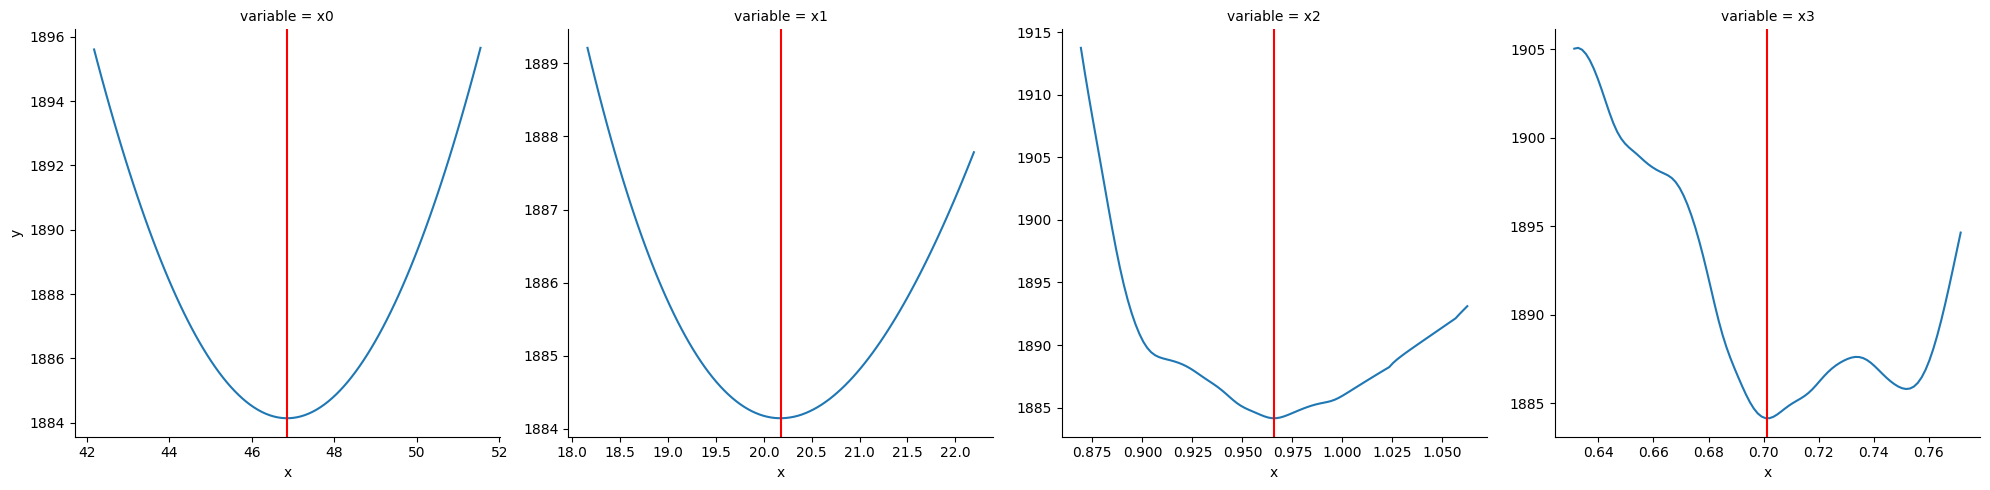

In [8]:
xsol = res.params
xrange = .1
theta_upper = xsol  + xrange *jnp.abs(xsol)
theta_lower = xsol - xrange * jnp.abs(xsol)
theta_rng_trans = jnp.array([theta_lower, theta_upper])

#res.params
theta_rng = jnp.transpose(theta_rng_trans)
theta_rng
# plot at the true value theta0
pjp.proj_plot(
    fun=negdmglik_jax,
    x_opt=xsol,
    x_lims=theta_rng, 
    n_pts=100, 
    opt_vlines=True
)